# Capstone Project - Comparing Cities of UK and India

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line to install geopy
from geopy.geocoders import Nominatim# convert an address into latitude and longitude values
from geopy.geocoders import Yandex# convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!pip install foursquare

Solving environment: done

# All requested packages already installed.

Solving environment: - ^C
failed

CondaError: KeyboardInterrupt



In [25]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    ------------------------------------------------------------
                       

### Get Cities Data

In [16]:
# Downloaded major cities data from wiki data. I have already downloaded data into csv and uploaded in github
url="https://github.com/pbindusagar/Coursera_Capstone/blob/master/data/Cities%20Data.csv"
html = pd.read_html(url)
df_cities = pd.DataFrame(html[0])
df_cities.head()

Unnamed: 0       City  Population Country                       Coordinates
0         NaN      Delhi    26495000   India  Point(77.216666666 28.666666666)
1         NaN     Mumbai    12442373   India  Point(72.833333333 18.966666666)
2         NaN  Bengaluru    11250000   India        Point(77.597963 12.969907)
3         NaN    Chennai    10265000   India                Point(80.27 13.09)
4         NaN  Hyderabad     9305000   India  Point(78.466666666 17.366666666)

### Clean the cities dataset

In [17]:
#split coordinates
df_cities[['Longitude','Latitude']] = df_cities['Coordinates'].str.split(' ',expand=True)
#clean coordinates
df_cities['Longitude'] = df_cities['Longitude'].str[6:]
df_cities['Latitude'] = df_cities['Latitude'].str[:-1]
#df[['V','allele']] = df['V'].str.split('-',expand=True)
df_cities=df_cities[pd.notnull(df_cities['Latitude'])]
df_cities=df_cities[pd.notnull(df_cities['Longitude'])]
df_cities.drop_duplicates()
#drop Coordinates as it's not needed anymore
df_cities.drop('Coordinates',axis=1, inplace=True)

df_cities.head()

Unnamed: 0       City  Population Country     Longitude      Latitude
0         NaN      Delhi    26495000   India  77.216666666  28.666666666
1         NaN     Mumbai    12442373   India  72.833333333  18.966666666
2         NaN  Bengaluru    11250000   India     77.597963     12.969907
3         NaN    Chennai    10265000   India         80.27         13.09
4         NaN  Hyderabad     9305000   India  78.466666666  17.366666666

Latitude and Longitude Columns have to be floats. let's fix that.

In [18]:
#Latitude and Longitude types are wrong
df_cities['Latitude']=df_cities['Latitude'].astype(float)
df_cities['Longitude']=df_cities['Longitude'].astype(float)
df_cities.dtypes

Unnamed: 0    float64
City           object
Population      int64
Country        object
Longitude     float64
Latitude      float64
dtype: object

Lets create a map with the cities of UK and India

In [26]:
map_world = folium.Map()

# add markers to map
for lat, lng, city in zip(df_cities['Latitude'], df_cities['Longitude'], df_cities['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_world)  
    
map_world

### Get the venues for each city

Configure Foursquare API Credentials

In [50]:
# The code was removed by Watson Studio for sharing.

In [54]:
import foursquare as fs
from foursquare_api_tools import foursquare_api_tools as ft
#some stuff to make it more interactive
import sys
import time
output_stream = sys.stdout
import time

#create an empty df
venues_ft = pd.DataFrame()
#define queries we want to pass the function. This are the categories we are interested in.
queries=['school','university','hospital','restaurant','coffee','entertainment','shops','playground','nightlife','lodging']

# Construct the client object as instructed in foursquare package
client = fs.Foursquare(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, version=VERSION)

#let's print for how many cities are we going to search for venues
print('I have to look for ',df_cities.shape[0],' cities.')
i=0
for i in range(i,df_cities.shape[0]):
    lat = df_cities.iloc[i,df_cities.columns.get_loc('Latitude')]
    long = df_cities.iloc[i,df_cities.columns.get_loc('Longitude')]
    #print(lat,long)
    try:
        for query in queries:
            new_venues=ft.venues_explore(client,lat=str(lat),lng=str(long),limit=1000, offset=2,query=query)
            print(new_venues)
            #foursquare give names of country and city in original langage and/or user submited of the place. We need the normal ones.
            new_venues['Country2']=df_cities.iloc[i,df_cities.columns.get_loc('Country')]
            new_venues['City2']=df_cities.iloc[i,df_cities.columns.get_loc('City')]
            new_venues['Query']=query
            venues_ft=venues_ft.append(new_venues)
            #print('shape %s\r'% venues_ft.shape) #for debug
    except Exception as e: 
        print(e)
        pass
    output_stream.write('%s\r' % i)
    output_stream.flush()
#use this in case you excecuted the for loop to get the venues from foursquare
df_DeCl_venues=venues_ft


print('I got {} venues with {} columns' .format(venues_ft.shape[0],venues_ft.shape[1]))

I have to look for  280  cities.
India
India
India
India
India
United Kingdom
     index                                          Address  \
0        0                                   103a Oxford St   
1        0                                   16 Stukeley St   
2        0                                   20 Dean's Yard   
3        0                                42-43 Maiden Lane   
4        0                                    Covent Garden   
5        0                               24 Great Chapel St   
6        0                                 71-75 Shelton St   
7        0                             71-75 Shelton Street   
8        0                                 2 Southampton Pl   
9        0                                  Elizabeth House   
10       0                                        York Road   
11       0                                 7-11 Stukeley St   
12       0                              55-59 Oxford Street   
13       0                              

In [59]:
df_DeCl_venues=venues_ft
print('We got {} venues using Foursquare' .format(df_DeCl_venues.shape[0]))

We got 38397 venues using Foursquare


In [61]:
print('There are {} venues in United Kindom' 
      .format(df_DeCl_venues.loc[df_DeCl_venues['Country2'] == 'United Kingdom'].shape[0]))

print('There are {} venues in India' 
      .format(df_DeCl_venues.loc[df_DeCl_venues['Country2'] == 'India'].shape[0]))

There are 33853 venues in United Kindom
There are 4544 venues in India


In [62]:
print('There are {} uniques categories.'.format(len(df_DeCl_venues['Category'].unique())))

There are 351 uniques categories.


In [63]:
df_DeCl_venues.head(5)

index                      Address        Category       City Country  \
0      0                                       School  New Delhi   India   
1      0                            4     High School  New Delhi   India   
2      0  4, Raj Niwas Marg, Delhi 54  Student Center              India   
3      0                            4     High School  New Delhi   India   
4      0  4, Raj Niwas Marg, Delhi 54  Student Center              India   

    Latitude  Longitude                           Name Country2  City2   Query  
0  28.673800  77.223600  Delhi United Christian School    India  Delhi  school  
1  28.671611  77.221483             St Xavier's School    India  Delhi  school  
2  28.667383  77.228450      St Xavier's Se Sec School    India  Delhi  school  
3  28.671611  77.221483             St Xavier's School    India  Delhi  school  
4  28.667383  77.228450      St Xavier's Se Sec School    India  Delhi  school

Let's check of all the venues have at least one value

In [64]:
df_DeCl_venues.loc[df_DeCl_venues['Category'].isna()]

Empty DataFrame
Columns: [index, Address, Category, City, Country, Latitude, Longitude, Name, Country2, City2, Query]
Index: []

One Hot encoding of the categories

In [65]:
# one hot encoding
cities_onehot = pd.get_dummies(df_DeCl_venues[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cities_onehot['City'] = df_DeCl_venues['City2'] 

# move neighborhood column to the first column
fixed_columns = [cities_onehot.columns[-1]] + list(cities_onehot.columns[:-1])
cities_onehot = cities_onehot[fixed_columns]

cities_onehot.head()

City  ATM  Accessories Store  Adult Education Center  Afghan Restaurant  \
0  Delhi    0                  0                       0                  0   
1  Delhi    0                  0                       0                  0   
2  Delhi    0                  0                       0                  0   
3  Delhi    0                  0                       0                  0   
4  Delhi    0                  0                       0                  0   

   African Restaurant  American Restaurant  Andhra Restaurant  Antique Shop  \
0                   0                    0                  0             0   
1                   0                    0                  0             0   
2                   0                    0                  0             0   
3                   0                    0                  0             0   
4                   0                    0                  0             0   

   Argentinian Restaurant  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0                       0            0                    0                 0   
1                       0            0                    0                 0   
2                       0            0                    0                 0   
3                       0            0                    0                 0   
4                       0            0                    0                 0   

   Assisted Living  Australian Restaurant  Auto Garage  Auto Workshop  \
0                0                      0            0              0   
1                0                      0            0              0   
2                0                      0            0              0   
3                0                      0            0              0   
4                0                      0            0              0   

   Awadhi Restaurant  BBQ Joint  Bagel Shop  Bakery  Bar  Beer Bar  \
0                  0          0           0       0    0         0   
1                  0          0           0       0    0         0   
2                  0          0           0       0    0         0   
3                  0          0           0       0    0         0   
4                  0          0           0       0    0         0   

   Beer Garden  Beer Store  Belgian Restaurant  Bengali Restaurant  \
0            0           0                   0                   0   
1            0           0                   0                   0   
2            0           0                   0                   0   
3            0           0                   0                   0   
4            0           0                   0                   0   

   Betting Shop  Bike Rental / Bike Share  Bike Shop  Bistro  Board Shop  \
0             0                         0          0       0           0   
1             0                         0          0       0           0   
2             0                         0          0       0           0   
3             0                         0          0       0           0   
4             0                         0          0       0           0   

   Bookstore  Boutique  Bowling Alley  Brasserie  Brazilian Restaurant  \
0          0         0              0          0                     0   
1          0         0              0          0                     0   
2          0         0              0          0                     0   
3          0         0              0          0                     0   
4          0         0              0          0                     0   

   Breakfast Spot  Brewery  Bridal Shop  Bubble Tea Shop  Buffet  Building  \
0               0        0            0                0       0         0   
1               0        0            0                0       0         0   
2               0        0            0                0       0         0   
3               0        0            0                0       0        

In [66]:
#And let's examine the new dataframe size.
cities_onehot.shape

(38397, 352)

In [67]:
#lets group by city

cities_grouped = cities_onehot.groupby('City').mean().reset_index()
cities_grouped.head()

City  ATM  Accessories Store  Adult Education Center  \
0     Aberdeen  0.0           0.003221                0.000000   
1    Ahmedabad  0.0           0.000000                0.210526   
2      Asansol  0.0           0.000000                0.000000   
3   Aurangabad  0.0           0.000000                0.000000   
4  Basingstoke  0.0           0.000000                0.000000   

   Afghan Restaurant  African Restaurant  American Restaurant  \
0                0.0                 0.0             0.012882   
1                0.0                 0.0             0.000000   
2                0.0                 0.0             0.000000   
3                0.0                 0.0             0.000000   
4                0.0                 0.0             0.000000   

   Andhra Restaurant  Antique Shop  Argentinian Restaurant  Art Gallery  \
0                0.0           0.0                     0.0          0.0   
1                0.0           0.0                     0.0          0.0   
2                0.0           0.0                     0.0          0.0   
3                0.0           0.0                     0.0          0.0   
4                0.0           0.0                     0.0          0.0   

   Arts & Crafts Store  Asian Restaurant  Assisted Living  \
0                  0.0          0.006441              0.0   
1                  0.0          0.000000              0.0   
2                  0.0          0.000000              0.0   
3                  0.0          0.000000              0.0   
4                  0.0          0.000000              0.0   

   Australian Restaurant  Auto Garage  Auto Workshop  Awadhi Restaurant  \
0                    0.0     0.009662            0.0                0.0   
1                    0.0     0.000000            0.0                0.0   
2                    0.0     0.000000            0.0                0.0   
3                    0.0     0.000000            0.0                0.0   
4                    0.0     0.000000            0.0                0.0   

   BBQ Joint  Bagel Shop    Bakery       Bar  Beer Bar  Beer Garden  \
0        0.0         0.0  0.016103  0.070853  0.024155          0.0   
1        0.0         0.0  0.000000  0.000000  0.000000          0.0   
2        0.0         0.0  0.000000  0.000000  0.000000          0.0   
3        0.0         0.0  0.000000  0.000000  0.000000          0.0   
4        0.0         0.0  0.000000  0.000000  0.000000          0.0   

   Beer Store  Belgian Restaurant  Bengali Restaurant  Betting Shop  \
0         0.0                 0.0                 0.0           0.0   
1         0.0                 0.0                 0.0           0.0   
2         0.0                 0.0                 0.0           0.0   
3         0.0                 0.0                 0.0           0.0   
4         0.0                 0.0                 0.0           0.0   

   Bike Rental / Bike Share  Bike Shop  Bistro  Board Shop  Bookstore  \
0                       0.0        0.0     0.0         0.0   0.008052   
1                       0.0        0.0     0.0         0.0   0.000000   
2                       0.0        0.0     0.0         0.0   0.000000   
3                       0.0        0.0     0.0         0.0   0.000000   
4                       0.0        0.0     0.0         0.0   0.000000   

   Boutique  Bowling Alley  Brasserie  Brazilian Restaurant  Breakfast Spot  \
0       0.0            0.0        0.0              0.006441             0.0   
1       0.0            0.0        0.0              0.000000             0.0   
2       0.0            0.0        0.0              0.000000             0.0   
3       0.0            0.0        0.0              0.000000             0.0   
4       0.0            0.0        0.0              0.000000             0.0   

   Brewery  Bridal Shop  Bubble Tea Shop  Buffet  Building  Burger Joint  \
0      0.0          0.0              0.0     0.0       0.0      0.006441   
1      0.0          0.0          

In [68]:
num_top_venues = 5

for city in cities_grouped['City']:
    print("----"+city+"----")
    temp = cities_grouped[cities_grouped['City'] == city].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aberdeen----
            venue  freq
0            Café  0.12
1             Bar  0.07
2     Coffee Shop  0.06
3             Pub  0.06
4  Clothing Store  0.03


----Ahmedabad----
                    venue  freq
0                  School  0.68
1  Adult Education Center  0.21
2             High School  0.11
3                     ATM  0.00
4             Music Store  0.00


----Asansol----
                         venue  freq
0                  High School   1.0
1                          ATM   0.0
2                       Office   0.0
3  Northeast Indian Restaurant   0.0
4      North Indian Restaurant   0.0


----Aurangabad----
            venue  freq
0  Student Center   0.4
1     High School   0.4
2          School   0.2
3             ATM   0.0
4    Music School   0.0


----Basingstoke----
                             venue  freq
0                   Driving School   0.4
1        College Academic Building   0.4
2                           School   0.2
3                              ATM  

In [69]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [70]:
#num_top_venues = len(df_DeCl_venues['Category'].unique())

num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = cities_grouped['City']

for ind in np.arange(cities_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cities_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted.head()

City      1st Most Common Venue   2nd Most Common Venue  \
0     Aberdeen                       Café                     Bar   
1    Ahmedabad                     School  Adult Education Center   
2      Asansol                High School         Doctor's Office   
3   Aurangabad             Student Center             High School   
4  Basingstoke  College Academic Building          Driving School   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                   Pub           Coffee Shop        Clothing Store   
1           High School                   Zoo      Doner Restaurant   
2      Doner Restaurant            Donut Shop        Driving School   
3                School                   Zoo    Donburi Restaurant   
4                School           Film Studio    Donburi Restaurant   

  6th Most Common Venue 7th Most Common Venue        8th Most Common Venue  \
0              Beer Bar           Supermarket               Sandwich Place   
1            Donut Shop        Driving School                  Dry Cleaner   
2           Dry Cleaner   Dumpling Restaurant  Eastern European Restaurant   
3      Doner Restaurant            Donut Shop               Driving School   
4      Doner Restaurant            Donut Shop                  Dry Cleaner   

  9th Most Common Venue       10th Most Common Venue  \
0           Pizza Place                Grocery Store   
1   Dumpling Restaurant  Eastern European Restaurant   
2     Electronics Store            Elementary School   
3           Dry Cleaner          Dumpling Restaurant   
4   Dumpling Restaurant  Eastern European Restaurant   

        11th Most Common Venue  12th Most Common Venue 13th Most Common Venue  \
0                   Restaurant  Furniture / Home Store               Pharmacy   
1            Electronics Store       Elementary School         Emergency Room   
2               Emergency Room                     Zoo     English Restaurant   
3  Eastern European Restaurant       Electronics Store      Elementary School   
4            Electronics Store                     Zoo         Emergency Room   

  14th Most Common Venue 15th Most Common Venue 16th Most Common Venue  \
0      Indian Restaurant             Playground          Shopping Mall   
1        Doctor's Office     English Restaurant  Entertainment Service   
2  Entertainment Service   Ethiopian Restaurant          Event Service   
3               Dive Bar         Emergency Room     English Restaurant   
4     English Restaurant  Entertainment Service   Ethiopian Restaurant   

  17th Most Common Venue 18th Most Common Venue 19th Most Common Venue  \
0                 Bakery  General Entertainment     Italian Restaurant   
1   Ethiopian Restaurant          Event Service            Event Space   
2            Event Space            Fabric Shop     Falafel Restaurant   
3  Entertainment Service   Ethiopian Restaurant          Event Service   
4          Event Service            Event Space            Fabric Shop   

  20th Most Common Venue  
0     Seafood Restaurant  
1            Fabric Shop  
2         Farmers Market  
3            Event Space  
4     Falafel Restaurant

## Cluster cities

In [77]:
# set number of clusters
kclusters = 5

cities_grouped_clustering = cities_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cities_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 2, 1, 3, 4, 4, 4, 3, 4, 4], dtype=int32)

In [78]:
# add clustering labels
city_venues_sorted.insert(0, 'Cluster Labels K-Means', kmeans.labels_)

city_merged = df_cities

# merge to add latitude/longitude for each neighborhood
city_merged = city_merged.join(city_venues_sorted.set_index('City'), on='City')

city_merged.head()

Unnamed: 0       City  Population Country  Longitude   Latitude  \
0         NaN      Delhi    26495000   India  77.216667  28.666667   
1         NaN     Mumbai    12442373   India  72.833333  18.966667   
2         NaN  Bengaluru    11250000   India  77.597963  12.969907   
3         NaN    Chennai    10265000   India  80.270000  13.090000   
4         NaN  Hyderabad     9305000   India  78.466667  17.366667   

   Cluster Labels K-Means 1st Most Common Venue 2nd Most Common Venue  \
0                     4.0     Indian Restaurant  Fast Food Restaurant   
1                     3.0           High School                School   
2                     4.0                  Café     Indian Restaurant   
3                     2.0                School           High School   
4                     NaN                   NaN                   NaN   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                  Café              Hospital           Snack Place   
1        Student Center   Monument / Landmark        Private School   
2                   Bar                   Pub           Coffee Shop   
3       Doctor's Office      Doner Restaurant            Donut Shop   
4                   NaN                   NaN                   NaN   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0            University    Chinese Restaurant   Dumpling Restaurant   
1                   Zoo    Donburi Restaurant      Doner Restaurant   
2        Clothing Store                Lounge            Donut Shop   
3        Driving School           Dry Cleaner   Dumpling Restaurant   
4                   NaN                   NaN                   NaN   

         9th Most Common Venue 10th Most Common Venue 11th Most Common Venue  \
0                  Pizza Place             Donut Shop           Burger Joint   
1                   Donut Shop         Driving School            Dry Cleaner   
2                     Hospital          Shopping Mall            High School   
3  Eastern European Restaurant      Electronics Store      Elementary School   
4                          NaN                    NaN                    NaN   

  12th Most Common Venue       13th Most Common Venue 14th Most Common Venue  \
0             Food Truck                  Coffee Shop         Sandwich Place   
1    Dumpling Restaurant  Eastern European Restaurant      Electronics Store   
2               Tea Room             Department Store     Chinese Restaurant   
3                    Zoo               Emergency Room     English Restaurant   
4                    NaN                          NaN                    NaN   

  15th Most Common Venue 16th Most Common Venue 17th Most Common Venue  \
0         Student Center     Italian Restaurant       Asian Restaurant   
1               Dive Bar      Elementary School         Emergency Room   
2  General Entertainment    Japanese Restaurant                Brewery   
3  Entertainment Service   Ethiopian Restaurant          Event Service   
4                    NaN                    NaN                    NaN   

          18th Most Common Venue 19th Most Common Venue 20th Most Common Venue  
0  Vegetarian / Vegan Restaurant            High School                 School  
1             English Restaurant  Entertainment Service   Ethiopian Restaurant  
2              Electronics Store             Playground     Italian Restaurant  
3                    Event Space            Fabric Shop     Falafel Restaurant  
4                            NaN                    NaN                    NaN

In [79]:
city_merged['Cluster Labels K-Means'].unique()

array([ 4.,  3.,  2., nan,  1.,  0.])

In [80]:
city_merged.loc[city_merged['Cluster Labels K-Means'].isnull()]

Unnamed: 0                    City  Population         Country  \
4           NaN               Hyderabad     9305000           India   
7           NaN               Allahabad     5954391           India   
12          NaN                  Jaipur     3073350           India   
14          NaN                Mirzapur     2496970           India   
16          NaN               Ghaziabad     2381452           India   
23          NaN                    Agra     1585704           India   
31          NaN                Jabalpur     1267564           India   
34          NaN                Varanasi     1198491           India   
37          NaN                Amritsar     1132383           India   
38          NaN                 Aligarh     1131160           India   
39          NaN                Bhiwandi     1125898           India   
41          NaN                 Gwalior     1101981           India   
42          NaN                  Howrah     1077075           India   
46          NaN                 Jodhpur     1033918           India   
48          NaN                    Kota     1001694           India   
49          NaN                Bareilly     1000000           India   
52          NaN                  Dispur      957352           India   
53          NaN                 Solapur      951558           India   
55          NaN               Muradabad      887871           India   
61          NaN      Thiruvananthapuram      743691           India   
62          NaN              Saharanpur      705478           India   
69          NaN                  Bhilai      625700           India   
70          NaN               Mangalore      623841           India   
71          NaN                 Cuttack      606007           India   
72          NaN                Dehradun      578420           India   
73          NaN                Durgapur      566517           India   
78          NaN                 Bikaner      529007           India   
79          NaN                Agartala      522613           India   
81          NaN                  Ujjain      515215           India   
84          NaN                  Jhansi      507000           India   
85          NaN              Ulhasnagar      506098           India   
87          NaN                 Belgaum      488157           India   
92          NaN                 Kurnool      457633           India   
94          NaN              Maheshtala      448317           India   
95          NaN                  Sangli      436639           India   
97          NaN                   Akola      425817           India   
98          NaN         Rajpur Sonarpur      424368           India   
100         NaN               Bhagalpur      410210           India   
101         NaN                 Patiala      406192           India   
102         NaN            South Dumdum      403316           India   
103         NaN                Rajarhat      402844           India   
104         NaN                  Kollam      397419           India   
105         NaN                Bhatpara      386019           India   
106         NaN                Kakinada      384182           India   
107         NaN                Panihati      377347           India   
108         NaN                  Rohtak      374292           India   
111         NaN                  Kadapa      344893           India   
112         NaN       Rajamahendravaram      341831           India   
114         NaN             Muzaffarpur      333200           India   
115         NaN             Muzaffarpur      333200           India   
116         NaN  Bilaspur, Chhattisgarh      331030           India   
117         NaN               Kamarhati      330211           India   
118         NaN                 Bijapur      327427           India   
119         NaN                  Satara      326789           India   
121         NaN               Bardhaman      314265           India   
122         NaN              

In [81]:
city_merged=city_merged[np.isfinite(city_merged['Cluster Labels K-Means'])]
city_merged.loc[city_merged['Cluster Labels K-Means'].isnull()]

Empty DataFrame
Columns: [Unnamed: 0, City, Population, Country, Longitude, Latitude, Cluster Labels K-Means, 1st Most Common Venue, 2nd Most Common Venue, 3rd Most Common Venue, 4th Most Common Venue, 5th Most Common Venue, 6th Most Common Venue, 7th Most Common Venue, 8th Most Common Venue, 9th Most Common Venue, 10th Most Common Venue, 11th Most Common Venue, 12th Most Common Venue, 13th Most Common Venue, 14th Most Common Venue, 15th Most Common Venue, 16th Most Common Venue, 17th Most Common Venue, 18th Most Common Venue, 19th Most Common Venue, 20th Most Common Venue]
Index: []

Finally, let's visualize the resulting clusters

In [82]:
# create map
map_clusters = folium.Map()

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['City'], city_merged['Cluster Labels K-Means']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

In [83]:
city_merged.loc[city_merged['Cluster Labels K-Means'] == 0, 
                     city_merged.columns[[1] + list(range(5, city_merged.shape[1]))]]

City   Latitude  Cluster Labels K-Means 1st Most Common Venue  \
82    Liverpool  53.416667                     0.0            University   
142    Plymouth  50.371389                     0.0            University   
152  Portsmouth  50.805833                     0.0            University   
153     Swansea  51.616667                     0.0     Elementary School   
179     Norwich  52.628056                     0.0            University   
227     Preston  53.759444                     0.0            University   

    2nd Most Common Venue 3rd Most Common Venue         4th Most Common Venue  \
82        Language School         Shopping Mall                  Music School   
142           High School                School  General College & University   
152           High School                School               Language School   
153            University        Nursery School                Cooking School   
179                School           High School        Adult Education Center   
227        Student Center                Office                Driving School   

           5th Most Common Venue 6th Most Common Venue  \
82      College Science Building        Student Center   
142                       Office        Student Center   
152         College & University          Music School   
153       Adult Education Center                School   
179               Driving School          Music School   
227  College Technology Building                School   

               7th Most Common Venue      8th Most Common Venue  \
82                 Electronics Store           Doner Restaurant   
142                Community College  College Academic Building   
152  College Administrative Building                        Zoo   
153                      Fabric Shop             Farmers Market   
179                              Zoo          Electronics Store   
227                              Zoo           Doner Restaurant   

    9th Most Common Venue 10th Most Common Venue 11th Most Common Venue  \
82             Donut Shop         Driving School            Dry Cleaner   
142           Dry Cleaner        Doctor's Office     Donburi Restaurant   
152      Doner Restaurant             Donut Shop         Driving School   
153      Doner Restaurant             Donut Shop         Driving School   
179      Doner Restaurant             Donut Shop            Dry Cleaner   
227            Donut Shop            Dry Cleaner    Dumpling Restaurant   

          12th Most Common Venue       13th Most Common Venue  \
82           Dumpling Restaurant  Eastern European Restaurant   
142                  Fabric Shop             Doner Restaurant   
152                  Dry Cleaner          Dumpling Restaurant   
153                  Dry Cleaner          Dumpling Restaurant   
179          Dumpling Restaurant  Eastern European Restaurant   
227  Eastern European Restaurant            Electronics Store   

          14th Most Common Venue 15th Most Common Venue  \
82             Elementary School        Doctor's Office   
142                  Event Space             Donut Shop   
152  Eastern European Restaurant      Electronics Store   
153  Eastern European Restaurant     Falafel Restaurant   
179            Elementary School        Doctor's Office   
227              Doctor's Office      Elementary School   

    16th Most Common Venue 17th Most Common Venue 18th Most Common Venue  \
82          Emergency Room     English Restaurant  Entertainment Service   
142         Driving School     English Restaurant         Emergency Room   
152      Elementary School         Emergency Room     English Restaurant   
153      Electronics Store        Doctor's Office         Emergency Room   
179         Emergency Room     English Restaurant  Entertainment Service   
227         Emergency Room     English Restaurant  Entertainment Service   

    19th Most Common Venue 20th Most Common Venue  
82    Ethiopian Restaurant          Event Service  


In [84]:
city_merged.loc[city_merged['Cluster Labels K-Means'] == 3, 
                     city_merged.columns[[1] + list(range(5, city_merged.shape[1]))]]

City   Latitude  Cluster Labels K-Means  \
1              Mumbai  18.966667                     3.0   
20             Bhopal  23.250000                     3.0   
21   Pimpri-Chinchwad  18.627778                     3.0   
25         Jamshedpur  22.800000                     3.0   
28         Aurangabad  19.880000                     3.0   
29             Rajkot  22.296908                     3.0   
43             Ranchi  23.355556                     3.0   
50         Coimbatore  11.000000                     3.0   
58          Jalandhar  31.325556                     3.0   
86              Jammu  32.733333                     3.0   
93            Udaipur  24.583333                     3.0   
120          Thrissur  10.520000                     3.0   
132         Tirupathi  13.650000                     3.0   
145             Derby  52.916667                     3.0   
157      Vizianagaram  18.116667                     3.0   
166         Kharagpur  22.330239                     3.0   
169          Solihull  52.413000                     3.0   
175              York  53.950000                     3.0   
188           Swindon  51.558333                     3.0   
223             Poole  50.716667                     3.0   
231          Brighton  50.824167                     3.0   
251            Slough  51.509722                     3.0   
264          Worthing  50.814711                     3.0   
270           Crawley  51.115700                     3.0   

            1st Most Common Venue   2nd Most Common Venue  \
1                     High School                  School   
20                    High School          Private School   
21                 Nursery School  Adult Education Center   
25      College Academic Building             High School   
28                 Student Center             High School   
29                         School             High School   
43                    High School                  School   
50         Adult Education Center             High School   
58                    High School          Private School   
86               Religious School             High School   
93                 Student Center                  School   
120        Adult Education Center             High School   
132                   High School          Driving School   
145                  Music School                  School   
157              Religious School             High School   
166                  Trade School             High School   
169                   High School          Private School   
175                   High School              University   
188                  Music School                  School   
223  General College & University             High School   
231                        School         Language School   
251                   High School                  School   
264                        School               Preschool   
270                        School             High School   

            3rd Most Common Venue   4th Most Common Venue  \
1                  Student Center     Monument / Landmark   
20                 Nursery School                     Zoo   
21                 Driving School             High School   
25                 Farmers Market      Falafel Restaurant   
28                         School                     Zoo   
29         Adult Education Center                     Zoo   
43                  Middle School            Music School   
50                 Student Center                  School   
58                Language School          Nursery School   
86              Elementary School      Donburi Restaurant   
93                Doctor's Office        Doner Restaurant   
120  General College & University                     Zoo   
132                  Music School         Doctor's Office   
145                       Daycare      Donburi Restaurant   
157                Private School                  School   
166           

In [85]:
city_merged.loc[city_merged['Cluster Labels K-Means'] == 4, 
                     city_merged.columns[[1] + list(range(5, city_merged.shape[1]))]]

City   Latitude  Cluster Labels K-Means  \
0                  Delhi  28.666667                     4.0   
2              Bengaluru  12.969907                     4.0   
5                 London  51.507222                     4.0   
8                   Pune  18.523611                     4.0   
9                  Surat  21.170000                     4.0   
10               Kolkata  22.541111                     4.0   
15                Nagpur  21.153889                     4.0   
17                Indore  22.720556                     4.0   
18              Vadodara  22.300000                     4.0   
19         Visakhapatnam  17.733333                     4.0   
22                 Patna  25.610000                     4.0   
32                 Thane  19.180000                     4.0   
36            Birmingham  52.480000                     4.0   
40           Navi Mumbai  19.030000                     4.0   
44            Chandigarh  30.735278                     4.0   
45            Vijayawada  16.516667                     4.0   
56                Mysore  12.308611                     4.0   
57               Gurgaon  28.466667                     4.0   
59           Bhubaneswar  20.264444                     4.0   
65                 Kochi   9.966667                     4.0   
67                 Noida  28.570000                     4.0   
68               Glasgow  55.860000                     4.0   
75            Manchester  53.466667                     4.0   
77               Bristol  51.450000                     4.0   
80             Sheffield  53.382500                     4.0   
83             Edinburgh  55.950000                     4.0   
88                 Leeds  53.799722                     4.0   
89             Leicester  52.633333                     4.0   
90               Jalgaon  21.002920                     4.0   
91               Jalgaon  21.016667                     4.0   
96             Kozhikode  11.250000                     4.0   
109             Coventry  52.416667                     4.0   
110              Cardiff  51.480000                     4.0   
113              Belfast  54.596389                     4.0   
125  Newcastle upon Tyne  54.977778                     4.0   
130           Nottingham  52.955000                     4.0   
133               Bolton  53.583333                     4.0   
134    Brighton and Hove  50.827778                     4.0   
139          Southampton  50.906944                     4.0   
144   Kingston upon Hull  53.744333                     4.0   
146          Southampton  50.906944                     4.0   
151       Stoke-on-Trent  53.000000                     4.0   
160             Aberdeen  57.150000                     4.0   
164          Bidhannagar  22.580000                     4.0   
165         Secunderabad  17.450000                     4.0   
182         Peterborough  52.583333                     4.0   
184          Bournemouth  50.720000                     4.0   
197           Warrington  53.387320                     4.0   
199         Huddersfield  53.645000                     4.0   
208              Newport  51.583333                     4.0   
212               Oxford  51.751944                     4.0   
216               Dundee  56.464000                     4.0   
221              Newport  51.583333                     4.0   
222           Gloucester  51.864444                     4.0   
229        Middlesbrough  54.573889                     4.0   
246               Exeter  50.721539                     4.0   
247            Cambridge  52.208056                     4.0   
250         High Wycombe  51.621667                     4.0   
255            Blackburn  53.744900                     4.0   
257           Cheltenham  51.896519                     4.0   
258           Chelmsford  51.736100                     4.0   
268          Basingstoke  51.266700                     4.0   
272              Salford  53.482778                

## Now lets cluster not with Foursquare categories but our own queries

In [86]:
df_DeCl_venues.groupby('City2').count()

index  Address  Category  City  Country  Latitude  \
City2                                                                    
Aberdeen              1242     1242      1242  1242     1242      1242   
Ahmedabad               19       19        19    19       19        19   
Asansol                  3        3         3     3        3         3   
Aurangabad               5        5         5     5        5         5   
Basingstoke              5        5         5     5        5         5   
Belfast               1192     1192      1192  1192     1192      1192   
Bengaluru              682      682       682   682      682       682   
Bhopal                   5        5         5     5        5         5   
Bhubaneswar             79       79        79    79       79        79   
Bidhannagar            353      353       353   353      353       353   
Birmingham            1278     1278      1278  1278     1278      1278   
Blackburn                5        5         5     5        5         5   
Bolton                 234      234       234   234      234       234   
Bournemouth            465      465       465   465      465       465   
Brighton                41       41        41    41       41        41   
Brighton and Hove     1794     1794      1794  1794     1794      1794   
Bristol               1776     1776      1776  1776     1776      1776   
Cambridge              534      534       534   534      534       534   
Cardiff               1282     1282      1282  1282     1282      1282   
Chandigarh             247      247       247   247      247       247   
Chelmsford             409      409       409   409      409       409   
Cheltenham             599      599       599   599      599       599   
Chennai                  9        9         9     9        9         9   
Coimbatore               7        7         7     7        7         7   
Coventry               802      802       802   802      802       802   
Crawley                  7        7         7     7        7         7   
Delhi                   95       95        95    95       95        95   
Derby                   18       18        18    18       18        18   
Dundee                 385      385       385   385      385       385   
Eastbourne             331      331       331   331      331       331   
Edinburgh             1918     1918      1918  1918     1918      1918   
Exeter                 509      509       509   509      509       509   
Faridabad                7        7         7     7        7         7   
Glasgow               1404     1404      1404  1404     1404      1404   
Gloucester               7        7         7     7        7         7   
Godavarikhani            3        3         3     3        3         3   
Guntur                   5        5         5     5        5         5   
Gurgaon                 11       11        11    11       11        11   
Guwahati                 5        5         5     5        5         5   
High Wycombe           317      317       317   317      317       317   
Huddersfield           311      311       311   311      311       311   
Imphal                   5        5         5     5        5         5   
Indore                   5        5         5     5        5         5   
Jalandhar               11       11        11    11       11        11   
Jalgaon                 72       72        72    72       72        72   
Jammu                    3        3         3     3        3         3   
Jamshedpur               3        3         3     3        3         3   
Kanpur                   5        5         5     5        5         5   
Kharagpur                5        5         5     5        5         5   
Kingston upon Hull     638      638       638   638      638       638   
Kochi                  349      349       349   349      349       349   
Kolkata                229      229       229   229      229       229   
Kozhikode                

In [87]:
df_DeCl_venues.head()

index                      Address        Category       City Country  \
0      0                                       School  New Delhi   India   
1      0                            4     High School  New Delhi   India   
2      0  4, Raj Niwas Marg, Delhi 54  Student Center              India   
3      0                            4     High School  New Delhi   India   
4      0  4, Raj Niwas Marg, Delhi 54  Student Center              India   

    Latitude  Longitude                           Name Country2  City2   Query  
0  28.673800  77.223600  Delhi United Christian School    India  Delhi  school  
1  28.671611  77.221483             St Xavier's School    India  Delhi  school  
2  28.667383  77.228450      St Xavier's Se Sec School    India  Delhi  school  
3  28.671611  77.221483             St Xavier's School    India  Delhi  school  
4  28.667383  77.228450      St Xavier's Se Sec School    India  Delhi  school

In [88]:
# one hot encoding
cities_onehot_query = pd.get_dummies(df_DeCl_venues[['Query']], prefix="", prefix_sep="")

# add city column back to dataframe
cities_onehot_query['City'] = df_DeCl_venues['City2'] 

# move city column to the first column
fixed_columns = [cities_onehot_query.columns[-1]] + list(cities_onehot_query.columns[:-1])
cities_onehot_query = cities_onehot_query[fixed_columns]

cities_onehot_query.head()

City  coffee  entertainment  hospital  nightlife  playground  restaurant  \
0  Delhi       0              0         0          0           0           0   
1  Delhi       0              0         0          0           0           0   
2  Delhi       0              0         0          0           0           0   
3  Delhi       0              0         0          0           0           0   
4  Delhi       0              0         0          0           0           0   

   school  shops  university  
0       1      0           0  
1       1      0           0  
2       1      0           0  
3       1      0           0  
4       1      0           0

In [89]:
#lets group by city

cities_grouped_query = cities_onehot_query.groupby('City').mean().reset_index()
cities_grouped_query.head()

City  coffee  entertainment  hospital  nightlife  playground  \
0     Aberdeen  0.1562       0.014493  0.008052   0.185185    0.017713   
1    Ahmedabad  0.0000       0.000000  0.000000   0.000000    0.000000   
2      Asansol  0.0000       0.000000  0.000000   0.000000    0.000000   
3   Aurangabad  0.0000       0.000000  0.000000   0.000000    0.000000   
4  Basingstoke  0.0000       0.000000  0.000000   0.000000    0.000000   

   restaurant    school    shops  university  
0    0.256039  0.027375  0.31723    0.017713  
1    0.000000  1.000000  0.00000    0.000000  
2    0.000000  1.000000  0.00000    0.000000  
3    0.000000  1.000000  0.00000    0.000000  
4    0.000000  1.000000  0.00000    0.000000

In [90]:
num_top_venues = 5

for city in cities_grouped_query['City']:
    print("----"+city+"----")
    temp = cities_grouped_query[cities_grouped_query['City'] == city].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aberdeen----
        venue  freq
0       shops  0.32
1  restaurant  0.26
2   nightlife  0.19
3      coffee  0.16
4      school  0.03


----Ahmedabad----
           venue  freq
0         school   1.0
1         coffee   0.0
2  entertainment   0.0
3       hospital   0.0
4      nightlife   0.0


----Asansol----
           venue  freq
0         school   1.0
1         coffee   0.0
2  entertainment   0.0
3       hospital   0.0
4      nightlife   0.0


----Aurangabad----
           venue  freq
0         school   1.0
1         coffee   0.0
2  entertainment   0.0
3       hospital   0.0
4      nightlife   0.0


----Basingstoke----
           venue  freq
0         school   1.0
1         coffee   0.0
2  entertainment   0.0
3       hospital   0.0
4      nightlife   0.0


----Belfast----
           venue  freq
0     restaurant  0.34
1         coffee  0.29
2          shops  0.28
3  entertainment  0.03
4         school  0.03


----Bengaluru----
        venue  freq
0  restaurant  0.29
1      coffee 

In [91]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted_query = pd.DataFrame(columns=columns)
city_venues_sorted_query['City'] = cities_grouped_query['City']

for ind in np.arange(cities_grouped_query.shape[0]):
    city_venues_sorted_query.iloc[ind, 1:] = return_most_common_venues(cities_grouped_query.iloc[ind, :], num_top_venues)

city_venues_sorted_query.head()

City 1st Most Common Venue 2nd Most Common Venue  \
0     Aberdeen                 shops            restaurant   
1    Ahmedabad                school            university   
2      Asansol                school            university   
3   Aurangabad                school            university   
4  Basingstoke                school            university   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0             nightlife                coffee                school  
1                 shops            restaurant            playground  
2                 shops            restaurant            playground  
3                 shops            restaurant            playground  
4                 shops            restaurant            playground

In [92]:
# set number of clusters
kclusters = 5

cities_grouped_clustering_query = cities_grouped_query.drop('City', 1)

# run k-means clustering
kmeans_q = KMeans(n_clusters=kclusters, random_state=0).fit(cities_grouped_clustering_query)

# check cluster labels generated for each row in the dataframe
kmeans_q.labels_[0:10]

array([1, 0, 0, 0, 0, 4, 1, 0, 4, 3], dtype=int32)

In [94]:
# add clustering labels
city_venues_sorted_query.insert(0, 'Cluster Labels K-Means Query', kmeans.labels_)

city_merged_query = df_cities

# merge to add latitude/longitude for each neighborhood
city_merged_query = city_merged_query.join(city_venues_sorted_query.set_index('City'), on='City')

city_merged_query.head()

Unnamed: 0       City  Population Country  Longitude   Latitude  \
0         NaN      Delhi    26495000   India  77.216667  28.666667   
1         NaN     Mumbai    12442373   India  72.833333  18.966667   
2         NaN  Bengaluru    11250000   India  77.597963  12.969907   
3         NaN    Chennai    10265000   India  80.270000  13.090000   
4         NaN  Hyderabad     9305000   India  78.466667  17.366667   

   Cluster Labels K-Means Query 1st Most Common Venue 2nd Most Common Venue  \
0                           4.0            restaurant              hospital   
1                           3.0                school            university   
2                           4.0            restaurant                coffee   
3                           2.0                school            university   
4                           NaN                   NaN                   NaN   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0                coffee            university                school  
1                 shops            restaurant            playground  
2                 shops             nightlife                school  
3                 shops            restaurant            playground  
4                   NaN                   NaN                   NaN

In [95]:
city_merged_query['Cluster Labels K-Means Query'].unique()

array([ 4.,  3.,  2., nan,  1.,  0.])

In [96]:
city_merged_query.loc[city_merged_query['Cluster Labels K-Means Query'].isnull()]

Unnamed: 0                    City  Population         Country  \
4           NaN               Hyderabad     9305000           India   
7           NaN               Allahabad     5954391           India   
12          NaN                  Jaipur     3073350           India   
14          NaN                Mirzapur     2496970           India   
16          NaN               Ghaziabad     2381452           India   
23          NaN                    Agra     1585704           India   
31          NaN                Jabalpur     1267564           India   
34          NaN                Varanasi     1198491           India   
37          NaN                Amritsar     1132383           India   
38          NaN                 Aligarh     1131160           India   
39          NaN                Bhiwandi     1125898           India   
41          NaN                 Gwalior     1101981           India   
42          NaN                  Howrah     1077075           India   
46          NaN                 Jodhpur     1033918           India   
48          NaN                    Kota     1001694           India   
49          NaN                Bareilly     1000000           India   
52          NaN                  Dispur      957352           India   
53          NaN                 Solapur      951558           India   
55          NaN               Muradabad      887871           India   
61          NaN      Thiruvananthapuram      743691           India   
62          NaN              Saharanpur      705478           India   
69          NaN                  Bhilai      625700           India   
70          NaN               Mangalore      623841           India   
71          NaN                 Cuttack      606007           India   
72          NaN                Dehradun      578420           India   
73          NaN                Durgapur      566517           India   
78          NaN                 Bikaner      529007           India   
79          NaN                Agartala      522613           India   
81          NaN                  Ujjain      515215           India   
84          NaN                  Jhansi      507000           India   
85          NaN              Ulhasnagar      506098           India   
87          NaN                 Belgaum      488157           India   
92          NaN                 Kurnool      457633           India   
94          NaN              Maheshtala      448317           India   
95          NaN                  Sangli      436639           India   
97          NaN                   Akola      425817           India   
98          NaN         Rajpur Sonarpur      424368           India   
100         NaN               Bhagalpur      410210           India   
101         NaN                 Patiala      406192           India   
102         NaN            South Dumdum      403316           India   
103         NaN                Rajarhat      402844           India   
104         NaN                  Kollam      397419           India   
105         NaN                Bhatpara      386019           India   
106         NaN                Kakinada      384182           India   
107         NaN                Panihati      377347           India   
108         NaN                  Rohtak      374292           India   
111         NaN                  Kadapa      344893           India   
112         NaN       Rajamahendravaram      341831           India   
114         NaN             Muzaffarpur      333200           India   
115         NaN             Muzaffarpur      333200           India   
116         NaN  Bilaspur, Chhattisgarh      331030           India   
117         NaN               Kamarhati      330211           India   
118         NaN                 Bijapur      327427           India   
119         NaN                  Satara      326789           India   
121         NaN               Bardhaman      314265           India   
122         NaN              

In [97]:
city_merged_query=city_merged_query[np.isfinite(city_merged_query['Cluster Labels K-Means Query'])]

In [98]:
city_merged_query.loc[city_merged_query['Cluster Labels K-Means Query'].isnull()]

Empty DataFrame
Columns: [Unnamed: 0, City, Population, Country, Longitude, Latitude, Cluster Labels K-Means Query, 1st Most Common Venue, 2nd Most Common Venue, 3rd Most Common Venue, 4th Most Common Venue, 5th Most Common Venue]
Index: []

In [99]:
# create map
map_clusters_q = folium.Map()

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged_query['Latitude'], city_merged_query['Longitude'], city_merged_query['City'], city_merged_query['Cluster Labels K-Means Query']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters_q)
       
map_clusters_q

## Hierarchical cluster analysis

In [100]:
X = cities_grouped.drop('City', axis=1)
X.head()

ATM  Accessories Store  Adult Education Center  Afghan Restaurant  \
0  0.0           0.003221                0.000000                0.0   
1  0.0           0.000000                0.210526                0.0   
2  0.0           0.000000                0.000000                0.0   
3  0.0           0.000000                0.000000                0.0   
4  0.0           0.000000                0.000000                0.0   

   African Restaurant  American Restaurant  Andhra Restaurant  Antique Shop  \
0                 0.0             0.012882                0.0           0.0   
1                 0.0             0.000000                0.0           0.0   
2                 0.0             0.000000                0.0           0.0   
3                 0.0             0.000000                0.0           0.0   
4                 0.0             0.000000                0.0           0.0   

   Argentinian Restaurant  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0                     0.0          0.0                  0.0          0.006441   
1                     0.0          0.0                  0.0          0.000000   
2                     0.0          0.0                  0.0          0.000000   
3                     0.0          0.0                  0.0          0.000000   
4                     0.0          0.0                  0.0          0.000000   

   Assisted Living  Australian Restaurant  Auto Garage  Auto Workshop  \
0              0.0                    0.0     0.009662            0.0   
1              0.0                    0.0     0.000000            0.0   
2              0.0                    0.0     0.000000            0.0   
3              0.0                    0.0     0.000000            0.0   
4              0.0                    0.0     0.000000            0.0   

   Awadhi Restaurant  BBQ Joint  Bagel Shop    Bakery       Bar  Beer Bar  \
0                0.0        0.0         0.0  0.016103  0.070853  0.024155   
1                0.0        0.0         0.0  0.000000  0.000000  0.000000   
2                0.0        0.0         0.0  0.000000  0.000000  0.000000   
3                0.0        0.0         0.0  0.000000  0.000000  0.000000   
4                0.0        0.0         0.0  0.000000  0.000000  0.000000   

   Beer Garden  Beer Store  Belgian Restaurant  Bengali Restaurant  \
0          0.0         0.0                 0.0                 0.0   
1          0.0         0.0                 0.0                 0.0   
2          0.0         0.0                 0.0                 0.0   
3          0.0         0.0                 0.0                 0.0   
4          0.0         0.0                 0.0                 0.0   

   Betting Shop  Bike Rental / Bike Share  Bike Shop  Bistro  Board Shop  \
0           0.0                       0.0        0.0     0.0         0.0   
1           0.0                       0.0        0.0     0.0         0.0   
2           0.0                       0.0        0.0     0.0         0.0   
3           0.0                       0.0        0.0     0.0         0.0   
4           0.0                       0.0        0.0     0.0         0.0   

   Bookstore  Boutique  Bowling Alley  Brasserie  Brazilian Restaurant  \
0   0.008052       0.0            0.0        0.0              0.006441   
1   0.000000       0.0            0.0        0.0              0.000000   
2   0.000000       0.0            0.0        0.0              0.000000   
3   0.000000       0.0            0.0        0.0              0.000000   
4   0.000000       0.0            0.0        0.0              0.000000   

   Breakfast Spot  Brewery  Bridal Shop  Bubble Tea Shop  Buffet  Building  \
0             0.0      0.0          0.0              0.0     0.0       0.0   
1             0.0      0.0          0.0              0.0     0.0       0.0   
2             0.0      0.0          0.0              0.0     0.0       0.0   
3             0.0      0.0          0.0              0.0     0.0       

In [101]:
X.shape

(118, 351)

In [102]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))  
plt.title("Cities Dendograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))  
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

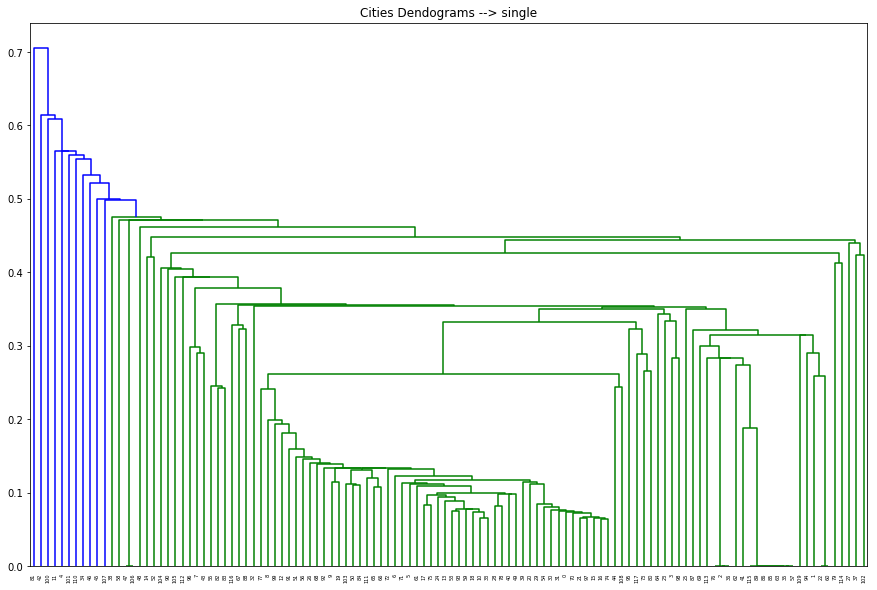

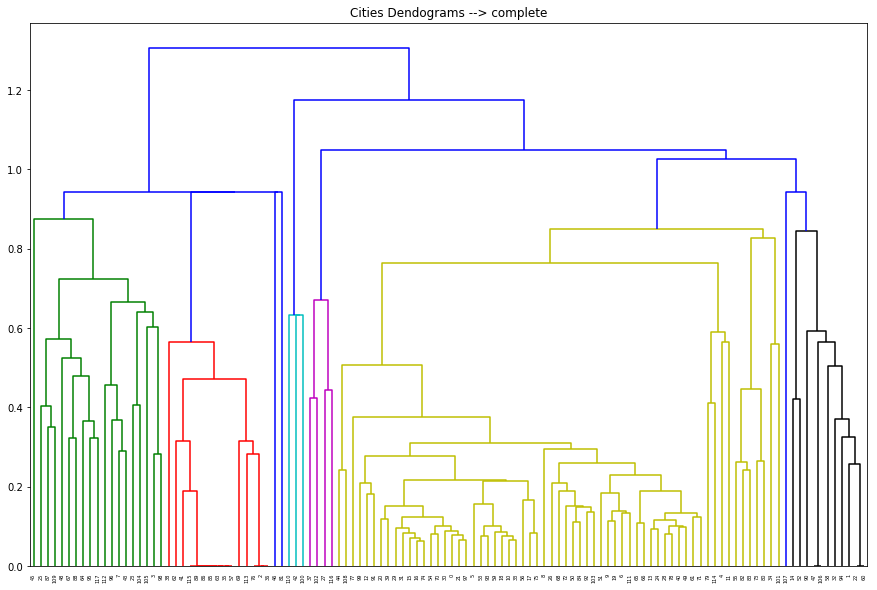

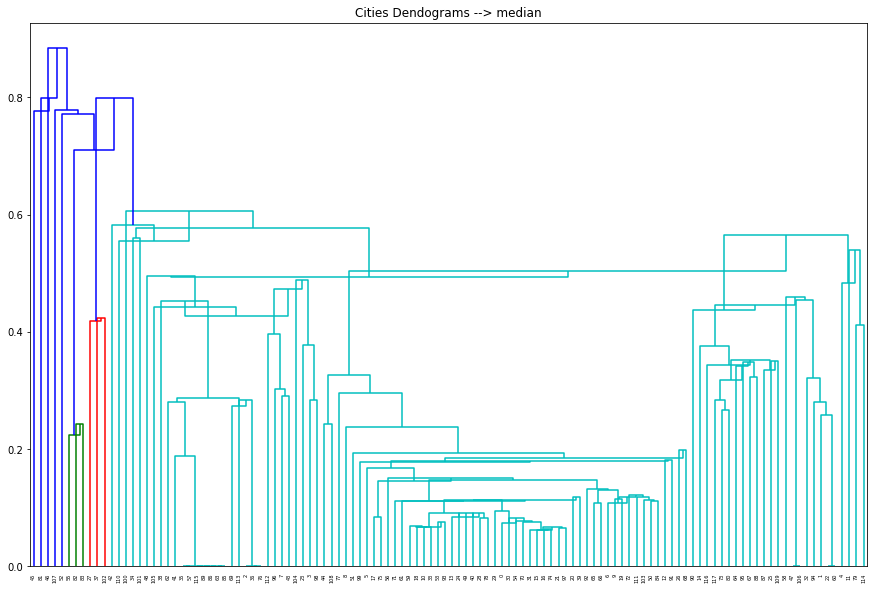

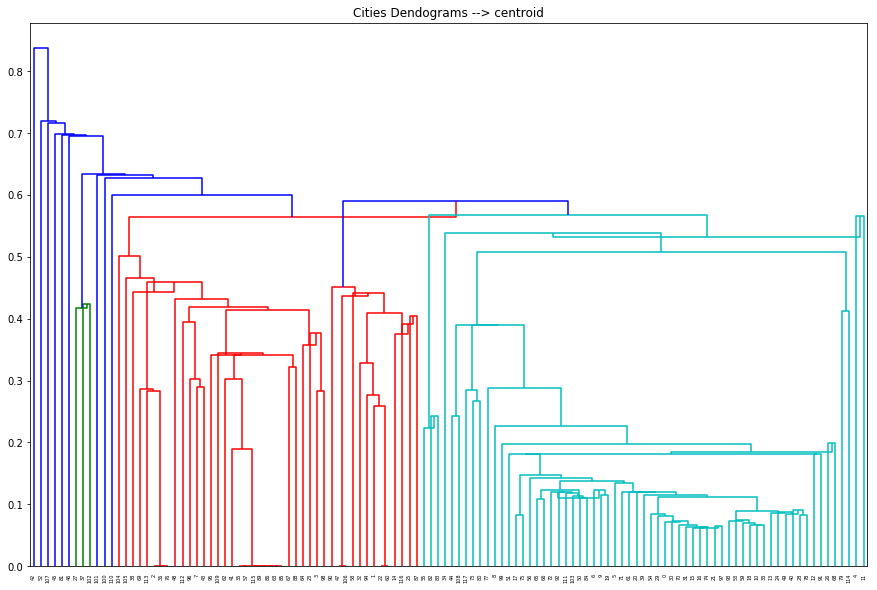

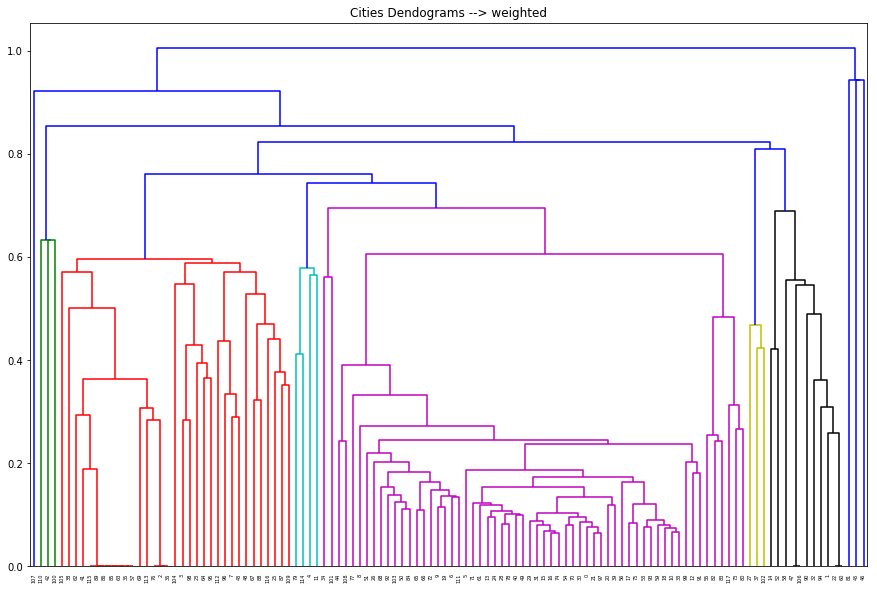

In [103]:
#fig, axes23 = plt.subplots(2, 3)
fig = plt.figure()
methods=['single', 'complete','median','centroid','weighted']
for method, num in zip(methods, range(0,len(methods))):
    plt.figure(figsize=(15, 10))  
    plt.title("Cities Dendograms --> "+str(method))
    dend = shc.dendrogram(shc.linkage(X, method=method))
    plt.show()

## We will use 7 clusters based on weighted hierarchical clustering plot

In [104]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='complete')  
cluster.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='complete', memory=None,
            n_clusters=7, pooling_func='deprecated')

In [105]:
print(cluster.labels_)
city_venues_sorted_h=cities_grouped[:]
city_venues_sorted_h.insert(0, 'Cluster Labels Hierarchical', cluster.labels_)

[1 4 0 2 1 1 1 2 1 1 1 1 1 1 4 1 1 1 1 1 1 1 4 2 1 2 1 3 1 1 1 1 4 1 1 0 0
 3 0 1 1 0 5 2 1 2 0 4 2 1 1 1 4 1 1 1 1 0 4 1 4 1 0 0 2 1 1 2 1 0 1 1 1 1
 1 1 0 1 1 1 1 0 1 1 1 0 0 2 2 0 4 1 1 1 4 2 2 1 2 1 5 1 3 1 2 2 4 6 1 2 5
 1 2 0 1 0 3 2]


In [106]:
city_venues_sorted_h.head()

Cluster Labels Hierarchical         City  ATM  Accessories Store  \
0                            1     Aberdeen  0.0           0.003221   
1                            4    Ahmedabad  0.0           0.000000   
2                            0      Asansol  0.0           0.000000   
3                            2   Aurangabad  0.0           0.000000   
4                            1  Basingstoke  0.0           0.000000   

   Adult Education Center  Afghan Restaurant  African Restaurant  \
0                0.000000                0.0                 0.0   
1                0.210526                0.0                 0.0   
2                0.000000                0.0                 0.0   
3                0.000000                0.0                 0.0   
4                0.000000                0.0                 0.0   

   American Restaurant  Andhra Restaurant  Antique Shop  \
0             0.012882                0.0           0.0   
1             0.000000                0.0           0.0   
2             0.000000                0.0           0.0   
3             0.000000                0.0           0.0   
4             0.000000                0.0           0.0   

   Argentinian Restaurant  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0                     0.0          0.0                  0.0          0.006441   
1                     0.0          0.0                  0.0          0.000000   
2                     0.0          0.0                  0.0          0.000000   
3                     0.0          0.0                  0.0          0.000000   
4                     0.0          0.0                  0.0          0.000000   

   Assisted Living  Australian Restaurant  Auto Garage  Auto Workshop  \
0              0.0                    0.0     0.009662            0.0   
1              0.0                    0.0     0.000000            0.0   
2              0.0                    0.0     0.000000            0.0   
3              0.0                    0.0     0.000000            0.0   
4              0.0                    0.0     0.000000            0.0   

   Awadhi Restaurant  BBQ Joint  Bagel Shop    Bakery       Bar  Beer Bar  \
0                0.0        0.0         0.0  0.016103  0.070853  0.024155   
1                0.0        0.0         0.0  0.000000  0.000000  0.000000   
2                0.0        0.0         0.0  0.000000  0.000000  0.000000   
3                0.0        0.0         0.0  0.000000  0.000000  0.000000   
4                0.0        0.0         0.0  0.000000  0.000000  0.000000   

   Beer Garden  Beer Store  Belgian Restaurant  Bengali Restaurant  \
0          0.0         0.0                 0.0                 0.0   
1          0.0         0.0                 0.0                 0.0   
2          0.0         0.0                 0.0                 0.0   
3          0.0         0.0                 0.0                 0.0   
4          0.0         0.0                 0.0                 0.0   

   Betting Shop  Bike Rental / Bike Share  Bike Shop  Bistro  Board Shop  \
0           0.0                       0.0        0.0     0.0         0.0   
1           0.0                       0.0        0.0     0.0         0.0   
2           0.0                       0.0        0.0     0.0         0.0   
3           0.0                       0.0        0.0     0.0         0.0   
4           0.0                       0.0        0.0     0.0         0.0   

   Bookstore  Boutique  Bowling Alley  Brasserie  Brazilian Restaurant  \
0   0.008052       0.0            0.0        0.0              0.006441   
1   0.000000       0.0            0.0        0.0              0.000000   
2   0.000000       0.0            0.0        0.0              0.000000   
3   0.000000       0.0            0.0        0.0              0.000000   
4   0.000000       0.0            0.0        0.0              0.000000   

   Breakfast Spot  Brewery  Bridal Shop  Bubble Tea Shop  Buffet  Building  \
0             0.0     

In [108]:
#Let's add coordinates to the dataset again to plot
city_merged_h = df_cities

# merge to add latitude/longitude for each neighborhood
city_merged_h = city_merged_h.join(city_venues_sorted_h.set_index('City'), on='City')
#clean nan values
city_merged_h=city_merged_h[np.isfinite(city_merged_h['Cluster Labels Hierarchical'])]
city_merged_h.head()

Unnamed: 0       City  Population         Country  Longitude   Latitude  \
0         NaN      Delhi    26495000           India  77.216667  28.666667   
1         NaN     Mumbai    12442373           India  72.833333  18.966667   
2         NaN  Bengaluru    11250000           India  77.597963  12.969907   
3         NaN    Chennai    10265000           India  80.270000  13.090000   
5         NaN     London     8908081  United Kingdom  -0.127500  51.507222   

   Cluster Labels Hierarchical  ATM  Accessories Store  \
0                          1.0  0.0           0.000000   
1                          2.0  0.0           0.000000   
2                          1.0  0.0           0.002933   
3                          4.0  0.0           0.000000   
5                          1.0  0.0           0.001512   

   Adult Education Center  Afghan Restaurant  African Restaurant  \
0                0.000000           0.000000                 0.0   
1                0.000000           0.000000                 0.0   
2                0.000000           0.002933                 0.0   
3                0.000000           0.000000                 0.0   
5                0.004535           0.000000                 0.0   

   American Restaurant  Andhra Restaurant  Antique Shop  \
0             0.000000           0.000000           0.0   
1             0.000000           0.000000           0.0   
2             0.002933           0.002933           0.0   
3             0.000000           0.000000           0.0   
5             0.000000           0.000000           0.0   

   Argentinian Restaurant  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0                0.000000          0.0             0.000000          0.021053   
1                0.000000          0.0             0.000000          0.000000   
2                0.000000          0.0             0.000000          0.002933   
3                0.000000          0.0             0.000000          0.000000   
5                0.001512          0.0             0.001512          0.001512   

   Assisted Living  Australian Restaurant  Auto Garage  Auto Workshop  \
0              0.0                    0.0          0.0       0.000000   
1              0.0                    0.0          0.0       0.000000   
2              0.0                    0.0          0.0       0.002933   
3              0.0                    0.0          0.0       0.000000   
5              0.0                    0.0          0.0       0.000000   

   Awadhi Restaurant  BBQ Joint  Bagel Shop    Bakery       Bar  Beer Bar  \
0                0.0   0.000000    0.000000  0.000000  0.000000  0.000000   
1                0.0   0.000000    0.000000  0.000000  0.000000  0.000000   
2                0.0   0.002933    0.005865  0.011730  0.052786  0.000000   
3                0.0   0.000000    0.000000  0.000000  0.000000  0.000000   
5                0.0   0.000000    0.000000  0.018141  0.012094  0.006047   

   Beer Garden  Beer Store  Belgian Restaurant  Bengali Restaurant  \
0     0.000000    0.000000                 0.0                 0.0   
1     0.000000    0.000000                 0.0                 0.0   
2     0.002933    0.002933                 0.0                 0.0   
3     0.000000    0.000000                 0.0                 0.0   
5     0.000000    0.000000                 0.0                 0.0   

   Betting Shop  Bike Rental / Bike Share  Bike Shop    Bistro  Board Shop  \
0           0.0                       0.0   0.000000  0.000000         0.0   
1           0.0                       0.0   0.000000  0.000000         0.0   
2           0.0                       0.0   0.000000  0.005865         0.0   
3           0.0                       0.0   0.000000  0.000000         0.0   
5           0.0                       0.0   0.001512  0.000000         0.0   

   Bookstore  Boutique  Bowling Alley  Brasserie  Brazilian Restaurant  \
0   0.000000  0.000000       0.000000   0.000000                   0

In [109]:
# create map
map_clusters_h8 = folium.Map()

# set color scheme for the clusters
x = np.arange(9)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged_h['Latitude'], city_merged_h['Longitude'], city_merged_h['City'], city_merged_h['Cluster Labels Hierarchical']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-2],
        fill=True,
        fill_color=rainbow[int(cluster)-2],
        fill_opacity=0.7).add_to(map_clusters_h8)
       
map_clusters_h8

## Let's compare

In [110]:
i=0
for i in range(0,5):
    print('K-means for {} has {} cities' .format(i,city_merged.loc[city_merged['Cluster Labels K-Means'] == i].shape[0]))

K-means for 0 has 6 cities
K-means for 1 has 17 cities
K-means for 2 has 11 cities
K-means for 3 has 24 cities
K-means for 4 has 64 cities


In [111]:
i=0
for i in range(0,5):
    print('K-means for {} has {} cities' .format(i,city_merged_query.loc[city_merged_query['Cluster Labels K-Means Query'] == i].shape[0]))

K-means for 0 has 6 cities
K-means for 1 has 17 cities
K-means for 2 has 11 cities
K-means for 3 has 24 cities
K-means for 4 has 64 cities


In [112]:
i=0
for i in range(0,5):
    print('Hierarchical for {} has {} cities' .format(i,city_venues_sorted_h.loc[city_venues_sorted_h['Cluster Labels Hierarchical'] == i].shape[0]))

Hierarchical for 0 has 17 cities
Hierarchical for 1 has 63 cities
Hierarchical for 2 has 19 cities
Hierarchical for 3 has 4 cities
Hierarchical for 4 has 11 cities


## Look into a particular cluster

In [113]:
city_merged_h.head(3)

Unnamed: 0       City  Population Country  Longitude   Latitude  \
0         NaN      Delhi    26495000   India  77.216667  28.666667   
1         NaN     Mumbai    12442373   India  72.833333  18.966667   
2         NaN  Bengaluru    11250000   India  77.597963  12.969907   

   Cluster Labels Hierarchical  ATM  Accessories Store  \
0                          1.0  0.0           0.000000   
1                          2.0  0.0           0.000000   
2                          1.0  0.0           0.002933   

   Adult Education Center  Afghan Restaurant  African Restaurant  \
0                     0.0           0.000000                 0.0   
1                     0.0           0.000000                 0.0   
2                     0.0           0.002933                 0.0   

   American Restaurant  Andhra Restaurant  Antique Shop  \
0             0.000000           0.000000           0.0   
1             0.000000           0.000000           0.0   
2             0.002933           0.002933           0.0   

   Argentinian Restaurant  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0                     0.0          0.0                  0.0          0.021053   
1                     0.0          0.0                  0.0          0.000000   
2                     0.0          0.0                  0.0          0.002933   

   Assisted Living  Australian Restaurant  Auto Garage  Auto Workshop  \
0              0.0                    0.0          0.0       0.000000   
1              0.0                    0.0          0.0       0.000000   
2              0.0                    0.0          0.0       0.002933   

   Awadhi Restaurant  BBQ Joint  Bagel Shop   Bakery       Bar  Beer Bar  \
0                0.0   0.000000    0.000000  0.00000  0.000000       0.0   
1                0.0   0.000000    0.000000  0.00000  0.000000       0.0   
2                0.0   0.002933    0.005865  0.01173  0.052786       0.0   

   Beer Garden  Beer Store  Belgian Restaurant  Bengali Restaurant  \
0     0.000000    0.000000                 0.0                 0.0   
1     0.000000    0.000000                 0.0                 0.0   
2     0.002933    0.002933                 0.0                 0.0   

   Betting Shop  Bike Rental / Bike Share  Bike Shop    Bistro  Board Shop  \
0           0.0                       0.0        0.0  0.000000         0.0   
1           0.0                       0.0        0.0  0.000000         0.0   
2           0.0                       0.0        0.0  0.005865         0.0   

   Bookstore  Boutique  Bowling Alley  Brasserie  Brazilian Restaurant  \
0   0.000000  0.000000       0.000000        0.0                   0.0   
1   0.000000  0.000000       0.000000        0.0                   0.0   
2   0.008798  0.002933       0.002933        0.0                   0.0   

   Breakfast Spot   Brewery  Bridal Shop  Bubble Tea Shop  Buffet  Building  \
0         0.00000  0.000000          0.0              0.0     0.0       0.0   
1         0.00000  0.000000          0.0              0.0     0.0       0.0   
2         0.01173  0.014663          0.0              0.0     0.0       0.0   

   Burger Joint  Burrito Place  Business Service  Cafeteria      Café  \
0      0.021053            0.0          0.000000        0.0  0.105263   
1      0.000000            0.0          0.000000        0.0  0.000000   
2      0.005865            0.0          0.005865        0.0  0.140762   

   Camera Store  Candy Store  Cantonese Restaurant  Caribbean Restaurant  \
0           0.0     0.000000                   0.0                   0.0   
1           0.0     0.000000                   0.0                   0.0   
2           0.0     0.002933                   0.0                   0.0   

   Carpet Store  Casino  Caucasian Restaurant  Champagne Bar  Cheese Shop  \
0           0.0     0.0                   0.0            0.0          0.0   
1           0.0     0.0                   0.0            0.0          0.0   
2           0.0    

In [114]:
#cluster_type='Cluster Labels K-Means'
cluster_type='Cluster Labels Hierarchical'


city_merged_h.loc[city_merged_h[cluster_type] == 3, 
                     city_merged_h.columns[[1] + list(range(5, city_merged_h.shape[1]))]]

City   Latitude  Cluster Labels Hierarchical  ATM  Accessories Store  \
57    Gurgaon  28.466667                          3.0  0.0                0.0   
145     Derby  52.916667                          3.0  0.0                0.0   
188   Swindon  51.558333                          3.0  0.0                0.0   
264  Worthing  50.814711                          3.0  0.0                0.0   

     Adult Education Center  Afghan Restaurant  African Restaurant  \
57                 0.181818                0.0                 0.0   
145                0.000000                0.0                 0.0   
188                0.000000                0.0                 0.0   
264                0.000000                0.0                 0.0   

     American Restaurant  Andhra Restaurant  Antique Shop  \
57                   0.0                0.0           0.0   
145                  0.0                0.0           0.0   
188                  0.0                0.0           0.0   
264                  0.0                0.0           0.0   

     Argentinian Restaurant  Art Gallery  Arts & Crafts Store  \
57                      0.0          0.0                  0.0   
145                     0.0          0.0                  0.0   
188                     0.0          0.0                  0.0   
264                     0.0          0.0                  0.0   

     Asian Restaurant  Assisted Living  Australian Restaurant  Auto Garage  \
57                0.0              0.0                    0.0          0.0   
145               0.0              0.0                    0.0          0.0   
188               0.0              0.0                    0.0          0.0   
264               0.0              0.0                    0.0          0.0   

     Auto Workshop  Awadhi Restaurant  BBQ Joint  Bagel Shop  Bakery  Bar  \
57             0.0                0.0        0.0         0.0     0.0  0.0   
145            0.0                0.0        0.0         0.0     0.0  0.0   
188            0.0                0.0        0.0         0.0     0.0  0.0   
264            0.0                0.0        0.0         0.0     0.0  0.0   

     Beer Bar  Beer Garden  Beer Store  Belgian Restaurant  \
57        0.0          0.0         0.0                 0.0   
145       0.0          0.0         0.0                 0.0   
188       0.0          0.0         0.0                 0.0   
264       0.0          0.0         0.0                 0.0   

     Bengali Restaurant  Betting Shop  Bike Rental / Bike Share  Bike Shop  \
57                  0.0           0.0                       0.0        0.0   
145                 0.0           0.0                       0.0        0.0   
188                 0.0           0.0                       0.0        0.0   
264                 0.0           0.0                       0.0        0.0   

     Bistro  Board Shop  Bookstore  Boutique  Bowling Alley  Brasserie  \
57      0.0         0.0        0.0       0.0            0.0        0.0   
145     0.0         0.0        0.0       0.0            0.0        0.0   
188     0.0         0.0        0.0       0.0            0.0        0.0   
264     0.0         0.0        0.0       0.0            0.0        0.0   

     Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
57                    0.0             0.0      0.0          0.0   
145                   0.0             0.0      0.0          0.0   
188                   0.0             0.0      0.0          0.0   
264                   0.0             0.0      0.0          0.0   

     Bubble Tea Shop  Buffet  Building  Burger Joint  Burrito Place  \
57               0.0     0.0       0.0           0.0            0.0   
145              0.0     0.0       0.0           0.0            0.0   
188              0.0     0.0       0.0           0.0            0.0   
264              0.0     0.0       0.0           0.0            0.0   

     Business Service  Cafeteria  Café  Camera Store  Candy Store  \
57       

## Search for a particular city

In [116]:
search_city='London'

city_merged_h.loc[city_merged_h['City'] == search_city, 
                     city_merged_h.columns[[1] + list(range(5, city_merged_h.shape[1]))]]

City   Latitude  Cluster Labels Hierarchical  ATM  Accessories Store  \
5  London  51.507222                          1.0  0.0           0.001512   

   Adult Education Center  Afghan Restaurant  African Restaurant  \
5                0.004535                0.0                 0.0   

   American Restaurant  Andhra Restaurant  Antique Shop  \
5                  0.0                0.0           0.0   

   Argentinian Restaurant  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
5                0.001512          0.0             0.001512          0.001512   

   Assisted Living  Australian Restaurant  Auto Garage  Auto Workshop  \
5              0.0                    0.0          0.0            0.0   

   Awadhi Restaurant  BBQ Joint  Bagel Shop    Bakery       Bar  Beer Bar  \
5                0.0        0.0         0.0  0.018141  0.012094  0.006047   

   Beer Garden  Beer Store  Belgian Restaurant  Bengali Restaurant  \
5          0.0         0.0                 0.0                 0.0   

   Betting Shop  Bike Rental / Bike Share  Bike Shop  Bistro  Board Shop  \
5           0.0                       0.0   0.001512     0.0         0.0   

   Bookstore  Boutique  Bowling Alley  Brasserie  Brazilian Restaurant  \
5   0.015117  0.008314            0.0   0.001512                   0.0   

   Breakfast Spot  Brewery  Bridal Shop  Bubble Tea Shop  Buffet  Building  \
5        0.003023      0.0          0.0         0.001512     0.0  0.001512   

   Burger Joint  Burrito Place  Business Service  Cafeteria      Café  \
5      0.004535            0.0               0.0        0.0  0.033258   

   Camera Store  Candy Store  Cantonese Restaurant  Caribbean Restaurant  \
5           0.0     0.001512                   0.0                   0.0   

   Carpet Store    Casino  Caucasian Restaurant  Champagne Bar  Cheese Shop  \
5           0.0  0.001512                   0.0            0.0          0.0   

   Chinese Restaurant  Chocolate Shop    Church  Circus School  \
5            0.001512        0.006047  0.001512       0.001512   

   Clothing Store  Cocktail Bar  Coffee Shop  College & University  \
5        0.033258      0.036281     0.050642                   0.0   

   College Academic Building  College Administrative Building  \
5                   0.007559                         0.006047   

   College Arts Building  College Auditorium  College Cafeteria  \
5               0.001512            0.001512                0.0   

   College Classroom  College Communications Building  \
5                0.0                              0.0   

   College Engineering Building  College Lab  College Library  \
5                           0.0          0.0         0.004535   

   College Math Building  College Quad  College Residence Hall  \
5                    0.0           0.0                0.001512   

   College Science Building  College Technology Building  College Theater  \
5                  0.001512                          0.0              0.0   

   Comedy Club  Comfort Food Restaurant  Comic Shop  Community Center  \
5          0.0                      0.0    0.003023               0.0   

   Community College  Concert Hall  Construction & Landscaping  \
5                0.0           0.0                         0.0   

   Convenience Store  Cooking School  Cosmetics Shop  Costume Shop  \
5                0.0        0.004535        0.006047           0.0   

   Coworking Space  Creperie  Cricket Ground  Cuban Restaurant  Cupcake Shop  \
5              0.0       0.0             0.0               0.0      0.001512   

   Currency Exchange  Dance Studio  Daycare  Deli / Bodega  Dentist's Office  \
5                0.0      0.001512      0.0       0.004535               0.0   

   Department Store  Design Studio  Dessert Shop  Dhaba  Dim Sum Restaurant  \
5          0.006047            0.0      0.001512    0.0            0.001512   

   Diner  Discount Store  Dive Bar  Doctor's Office  Donburi Restaurant  \
5    0.0           

In [117]:
city_merged_h.loc[city_merged_h.apply(lambda row: row.astype(str).str.contains('Zoo').any(), axis=1), 
                     city_merged_h.columns[[1] + list(range(5, city_merged_h.shape[1]))]]

Empty DataFrame
Columns: [City, Latitude, Cluster Labels Hierarchical, ATM, Accessories Store, Adult Education Center, Afghan Restaurant, African Restaurant, American Restaurant, Andhra Restaurant, Antique Shop, Argentinian Restaurant, Art Gallery, Arts & Crafts Store, Asian Restaurant, Assisted Living, Australian Restaurant, Auto Garage, Auto Workshop, Awadhi Restaurant, BBQ Joint, Bagel Shop, Bakery, Bar, Beer Bar, Beer Garden, Beer Store, Belgian Restaurant, Bengali Restaurant, Betting Shop, Bike Rental / Bike Share, Bike Shop, Bistro, Board Shop, Bookstore, Boutique, Bowling Alley, Brasserie, Brazilian Restaurant, Breakfast Spot, Brewery, Bridal Shop, Bubble Tea Shop, Buffet, Building, Burger Joint, Burrito Place, Business Service, Cafeteria, Café, Camera Store, Candy Store, Cantonese Restaurant, Caribbean Restaurant, Carpet Store, Casino, Caucasian Restaurant, Champagne Bar, Cheese Shop, Chinese Restaurant, Chocolate Shop, Church, Circus School, Clothing Store, Cocktail Bar, Coffee Shop, College & University, College Academic Building, College Administrative Building, College Arts Building, College Auditorium, College Cafeteria, College Classroom, College Communications Building, College Engineering Building, College Lab, College Library, College Math Building, College Quad, College Residence Hall, College Science Building, College Technology Building, College Theater, Comedy Club, Comfort Food Restaurant, Comic Shop, Community Center, Community College, Concert Hall, Construction & Landscaping, Convenience Store, Cooking School, Cosmetics Shop, Costume Shop, Coworking Space, Creperie, Cricket Ground, Cuban Restaurant, Cupcake Shop, Currency Exchange, ...]
Index: []

In [118]:
city_merged_h[city_merged_h['Cluster Labels Hierarchical'] == 2.0]

Unnamed: 0          City  Population         Country  Longitude  \
1           NaN        Mumbai    12442373           India  72.833333   
20          NaN        Bhopal     1883381           India  77.416667   
26          NaN        Nashik     1486053           India  73.783333   
28          NaN    Aurangabad     1371330           India  75.320000   
29          NaN        Rajkot     1335397           India  70.798364   
33          NaN   Vasai-Virar     1222390           India  72.800000   
35          NaN      Srinagar     1180570           India  74.806111   
43          NaN        Ranchi     1073440           India  85.334722   
50          NaN    Coimbatore      959823           India  76.966667   
58          NaN     Jalandhar      873725           India  75.579167   
86          NaN         Jammu      502197           India  74.850000   
120         NaN      Thrissur      315596           India  76.210000   
132         NaN     Tirupathi      287482           India  79.420000   
157         NaN  Vizianagaram      228720           India  83.416667   
166         NaN     Kharagpur      207604           India  87.323653   
169         NaN      Solihull      206674  United Kingdom  -1.772000   
175         NaN          York      198051  United Kingdom  -1.083333   
251         NaN        Slough      119070  United Kingdom  -0.593056   
270         NaN       Crawley      106597  United Kingdom  -0.193700   

      Latitude  Cluster Labels Hierarchical  ATM  Accessories Store  \
1    18.966667                          2.0  0.0                0.0   
20   23.250000                          2.0  0.0                0.0   
26   20.000000                          2.0  0.0                0.0   
28   19.880000                          2.0  0.0                0.0   
29   22.296908                          2.0  0.0                0.0   
33   19.470000                          2.0  0.0                0.0   
35   34.091111                          2.0  0.0                0.0   
43   23.355556                          2.0  0.0                0.0   
50   11.000000                          2.0  0.0                0.0   
58   31.325556                          2.0  0.0                0.0   
86   32.733333                          2.0  0.0                0.0   
120  10.520000                          2.0  0.0                0.0   
132  13.650000                          2.0  0.0                0.0   
157  18.116667                          2.0  0.0                0.0   
166  22.330239                          2.0  0.0                0.0   
169  52.413000                          2.0  0.0                0.0   
175  53.950000                          2.0  0.0                0.0   
251  51.509722                          2.0  0.0                0.0   
270  51.115700                          2.0  0.0                0.0   

     Adult Education Center  Afghan Restaurant  African Restaurant  \
1                  0.000000                0.0                 0.0   
20                 0.000000                0.0                 0.0   
26                 0.000000                0.0                 0.0   
28                 0.000000                0.0                 0.0   
29                 0.285714                0.0                 0.0   
33                 0.000000                0.0                 0.0   
35                 0.000000                0.0                 0.0   
43                 0.000000                0.0                 0.0   
50                 0.285714                0.0                 0.0   
58                 0.000000                0.0                 0.0   
86                 0.000000                0.0                 0.0   
120                0.444444                0.0                 0.0   
132                0.000000                0.0                 0.0   
157                0.000000                0.0                 0.0   
166                0.000000                0.0                 0.0   
169                0.00

## Most frequent venues for each cluster

In [119]:
city_venues_sorted_h.head()

Cluster Labels Hierarchical         City  ATM  Accessories Store  \
0                            1     Aberdeen  0.0           0.003221   
1                            4    Ahmedabad  0.0           0.000000   
2                            0      Asansol  0.0           0.000000   
3                            2   Aurangabad  0.0           0.000000   
4                            1  Basingstoke  0.0           0.000000   

   Adult Education Center  Afghan Restaurant  African Restaurant  \
0                0.000000                0.0                 0.0   
1                0.210526                0.0                 0.0   
2                0.000000                0.0                 0.0   
3                0.000000                0.0                 0.0   
4                0.000000                0.0                 0.0   

   American Restaurant  Andhra Restaurant  Antique Shop  \
0             0.012882                0.0           0.0   
1             0.000000                0.0           0.0   
2             0.000000                0.0           0.0   
3             0.000000                0.0           0.0   
4             0.000000                0.0           0.0   

   Argentinian Restaurant  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0                     0.0          0.0                  0.0          0.006441   
1                     0.0          0.0                  0.0          0.000000   
2                     0.0          0.0                  0.0          0.000000   
3                     0.0          0.0                  0.0          0.000000   
4                     0.0          0.0                  0.0          0.000000   

   Assisted Living  Australian Restaurant  Auto Garage  Auto Workshop  \
0              0.0                    0.0     0.009662            0.0   
1              0.0                    0.0     0.000000            0.0   
2              0.0                    0.0     0.000000            0.0   
3              0.0                    0.0     0.000000            0.0   
4              0.0                    0.0     0.000000            0.0   

   Awadhi Restaurant  BBQ Joint  Bagel Shop    Bakery       Bar  Beer Bar  \
0                0.0        0.0         0.0  0.016103  0.070853  0.024155   
1                0.0        0.0         0.0  0.000000  0.000000  0.000000   
2                0.0        0.0         0.0  0.000000  0.000000  0.000000   
3                0.0        0.0         0.0  0.000000  0.000000  0.000000   
4                0.0        0.0         0.0  0.000000  0.000000  0.000000   

   Beer Garden  Beer Store  Belgian Restaurant  Bengali Restaurant  \
0          0.0         0.0                 0.0                 0.0   
1          0.0         0.0                 0.0                 0.0   
2          0.0         0.0                 0.0                 0.0   
3          0.0         0.0                 0.0                 0.0   
4          0.0         0.0                 0.0                 0.0   

   Betting Shop  Bike Rental / Bike Share  Bike Shop  Bistro  Board Shop  \
0           0.0                       0.0        0.0     0.0         0.0   
1           0.0                       0.0        0.0     0.0         0.0   
2           0.0                       0.0        0.0     0.0         0.0   
3           0.0                       0.0        0.0     0.0         0.0   
4           0.0                       0.0        0.0     0.0         0.0   

   Bookstore  Boutique  Bowling Alley  Brasserie  Brazilian Restaurant  \
0   0.008052       0.0            0.0        0.0              0.006441   
1   0.000000       0.0            0.0        0.0              0.000000   
2   0.000000       0.0            0.0        0.0              0.000000   
3   0.000000       0.0            0.0        0.0              0.000000   
4   0.000000       0.0            0.0        0.0              0.000000   

   Breakfast Spot  Brewery  Bridal Shop  Bubble Tea Shop  Buffet  Building  \
0             0.0     

In [120]:
# one hot encoding

city_venues_sorted_ho = city_venues_sorted_h.drop('City',axis=1)
city_venues_sorted_ho = city_venues_sorted_ho.drop('Cluster Labels Hierarchical', axis=1)
cities_onehot_h = pd.get_dummies(city_venues_sorted_ho[9:], prefix="", prefix_sep="")

# add city column back to dataframe
cities_onehot_h['Cluster Labels Hierarchical'] = city_venues_sorted_h['Cluster Labels Hierarchical']

# move city column to the first column
fixed_columns = [cities_onehot_h.columns[-1]] + list(cities_onehot_h.columns[:-1])
cities_onehot_h = cities_onehot_h[fixed_columns]

cities_onehot_h.head()

Cluster Labels Hierarchical       ATM  Accessories Store  \
9                             1  0.045326                0.0   
10                            1  0.000000                0.0   
11                            1  0.000000                0.0   
12                            1  0.000000                0.0   
13                            1  0.000000                0.0   

    Adult Education Center  Afghan Restaurant  African Restaurant  \
9                  0.00000                0.0                 0.0   
10                 0.00626                0.0                 0.0   
11                 0.00000                0.0                 0.0   
12                 0.00000                0.0                 0.0   
13                 0.00000                0.0                 0.0   

    American Restaurant  Andhra Restaurant  Antique Shop  \
9              0.005666                0.0           0.0   
10             0.003130                0.0           0.0   
11             0.000000                0.0           0.0   
12             0.017094                0.0           0.0   
13             0.008602                0.0           0.0   

    Argentinian Restaurant  Art Gallery  Arts & Crafts Store  \
9                      0.0          0.0             0.005666   
10                     0.0          0.0             0.006260   
11                     0.0          0.0             0.000000   
12                     0.0          0.0             0.000000   
13                     0.0          0.0             0.000000   

    Asian Restaurant  Assisted Living  Australian Restaurant  Auto Garage  \
9           0.000000              0.0                    0.0      0.00000   
10          0.009390              0.0                    0.0      0.00313   
11          0.000000              0.0                    0.0      0.00000   
12          0.000000              0.0                    0.0      0.00000   
13          0.004301              0.0                    0.0      0.00000   

    Auto Workshop  Awadhi Restaurant  BBQ Joint  Bagel Shop    Bakery  \
9             0.0           0.005666        0.0         0.0  0.022663   
10            0.0           0.000000        0.0         0.0  0.006260   
11            0.0           0.000000        0.0         0.0  0.000000   
12            0.0           0.000000        0.0         0.0  0.017094   
13            0.0           0.000000        0.0         0.0  0.012903   

         Bar  Beer Bar  Beer Garden  Beer Store  Belgian Restaurant  \
9   0.016997       0.0          0.0         0.0                 0.0   
10  0.006260       0.0          0.0         0.0                 0.0   
11  0.000000       0.0          0.0         0.0                 0.0   
12  0.000000       0.0          0.0         0.0                 0.0   
13  0.004301       0.0          0.0         0.0                 0.0   

    Bengali Restaurant  Betting Shop  Bike Rental / Bike Share  Bike Shop  \
9             0.011331           0.0                       0.0        0.0   
10            0.000000           0.0                       0.0        0.0   
11            0.000000           0.0                       0.0        0.0   
12            0.000000           0.0                       0.0        0.0   
13            0.000000           0.0                       0.0        0.0   

     Bistro  Board Shop  Bookstore  Boutique  Bowling Alley  Brasserie  \
9   0.00000         0.0   0.008499  0.000000       0.005666        0.0   
10  0.01252         0.0   0.009390  0.006260       0.000000        0.0   
11  0.00000         0.0   0.000000  0.000000       0.000000        0.0   
12  0.00000         0.0   0.000000  0.000000       0.000000        0.0   
13  0.00000         0.0   0.008602  0.004301       0.000000        0.0   

    Brazilian Restaurant  Breakfast Spot   Brewery  Bridal Shop  \
9                0.00000        0.005666  0.005666          0.0   
10               0.00626        0.000000  0.000000          0.0   
11               0.0

In [121]:
cities_grouped_h = cities_onehot_h.groupby('Cluster Labels Hierarchical').mean().reset_index()
cities_grouped_h.head()

Cluster Labels Hierarchical       ATM  Accessories Store  \
0                            0  0.000000           0.000000   
1                            1  0.001083           0.002822   
2                            2  0.000000           0.000000   
3                            3  0.000000           0.000000   
4                            4  0.000000           0.000000   

   Adult Education Center  Afghan Restaurant  African Restaurant  \
0                0.000000           0.000000            0.000000   
1                0.007853           0.000049            0.000136   
2                0.067600           0.000000            0.000000   
3                0.045455           0.000000            0.000000   
4                0.000000           0.000000            0.000000   

   American Restaurant  Andhra Restaurant  Antique Shop  \
0             0.000000           0.000000      0.000000   
1             0.003333           0.000172      0.000171   
2             0.000000           0.000000      0.000000   
3             0.000000           0.000000      0.000000   
4             0.000000           0.000000      0.000000   

   Argentinian Restaurant  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0                 0.00000     0.000000             0.000000          0.000000   
1                 0.00005     0.000293             0.001509          0.007012   
2                 0.00000     0.000000             0.000000          0.000000   
3                 0.00000     0.000000             0.000000          0.000000   
4                 0.00000     0.000000             0.000000          0.000000   

   Assisted Living  Australian Restaurant  Auto Garage  Auto Workshop  \
0         0.000000               0.000000     0.000000       0.000000   
1         0.000043               0.000045     0.001952       0.000111   
2         0.000000               0.000000     0.000000       0.000000   
3         0.000000               0.000000     0.000000       0.000000   
4         0.000000               0.000000     0.000000       0.000000   

   Awadhi Restaurant  BBQ Joint  Bagel Shop    Bakery       Bar  Beer Bar  \
0           0.000000   0.000000    0.000000  0.000000  0.000000  0.000000   
1           0.000248   0.002241    0.000448  0.013284  0.012578  0.001104   
2           0.000000   0.000000    0.000000  0.000000  0.000000  0.000000   
3           0.000000   0.000000    0.000000  0.000000  0.000000  0.000000   
4           0.000000   0.000000    0.000000  0.000000  0.000000  0.000000   

   Beer Garden  Beer Store  Belgian Restaurant  Bengali Restaurant  \
0     0.000000    0.000000            0.000000            0.000000   
1     0.000247    0.000785            0.000044            0.000346   
2     0.000000    0.000000            0.000000            0.000000   
3     0.000000    0.000000            0.000000            0.000000   
4     0.000000    0.000000            0.000000            0.000000   

   Betting Shop  Bike Rental / Bike Share  Bike Shop    Bistro  Board Shop  \
0      0.000000                   0.00000   0.000000  0.000000    0.000000   
1      0.000841                   0.00004   0.000071  0.000769    0.000053   
2      0.000000                   0.00000   0.000000  0.000000    0.000000   
3      0.000000                   0.00000   0.000000  0.000000    0.000000   
4      0.000000                   0.00000   0.000000  0.000000    0.000000   

   Bookstore  Boutique  Bowling Alley  Brasserie  Brazilian Restaurant  \
0   0.000000  0.000000       0.000000   0.000000              0.000000   
1   0.006804  0.001949       0.000263   0.000026              0.000648   
2   0.000000  0.000000       0.000000   0.000000              0.000000   
3   0.000000  0.000000       0.000000   0.000000              0.000000   
4   0.000000  0.000000       0.000000   0.000000              0.000000   

   Breakfast Spot   Brewery  Bridal Shop  Bubble Tea Shop    Buffet  Building  \
0        0.000000  0.000000     0.000000          0.000

In [122]:
num_top_venues = 5

for city in cities_grouped_h['Cluster Labels Hierarchical']:
    print("----"+str(city)+"----")
    temp = cities_grouped_h[cities_grouped_h['Cluster Labels Hierarchical'] == city].T.reset_index()
    #print(temp)
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----0----
                          venue  freq
0                   High School  0.69
1                        School  0.17
2  General College & University  0.04
3     College Academic Building  0.04
4                     Preschool  0.02


----1----
               venue  freq
0               Café  0.09
1         University  0.08
2        Coffee Shop  0.05
3           Hospital  0.04
4  Indian Restaurant  0.04


----2----
                    venue  freq
0             High School  0.39
1                  School  0.17
2  Adult Education Center  0.07
3        Religious School  0.06
4          Student Center  0.05


----3----
          venue  freq
0  Music School  0.50
1        School  0.22
2       Daycare  0.06
3   High School  0.06
4     Preschool  0.06


----4----
                          venue  freq
0                        School  0.60
1               Language School  0.10
2                Nursery School  0.08
3  General College & University  0.06
4                   High School  0.06


In [123]:
Xq = cities_grouped_query.drop('City', axis=1)
Xq.head()

coffee  entertainment  hospital  nightlife  playground  restaurant  \
0  0.1562       0.014493  0.008052   0.185185    0.017713    0.256039   
1  0.0000       0.000000  0.000000   0.000000    0.000000    0.000000   
2  0.0000       0.000000  0.000000   0.000000    0.000000    0.000000   
3  0.0000       0.000000  0.000000   0.000000    0.000000    0.000000   
4  0.0000       0.000000  0.000000   0.000000    0.000000    0.000000   

     school    shops  university  
0  0.027375  0.31723    0.017713  
1  1.000000  0.00000    0.000000  
2  1.000000  0.00000    0.000000  
3  1.000000  0.00000    0.000000  
4  1.000000  0.00000    0.000000

In [124]:
cities_grouped_query.head()

City  coffee  entertainment  hospital  nightlife  playground  \
0     Aberdeen  0.1562       0.014493  0.008052   0.185185    0.017713   
1    Ahmedabad  0.0000       0.000000  0.000000   0.000000    0.000000   
2      Asansol  0.0000       0.000000  0.000000   0.000000    0.000000   
3   Aurangabad  0.0000       0.000000  0.000000   0.000000    0.000000   
4  Basingstoke  0.0000       0.000000  0.000000   0.000000    0.000000   

   restaurant    school    shops  university  
0    0.256039  0.027375  0.31723    0.017713  
1    0.000000  1.000000  0.00000    0.000000  
2    0.000000  1.000000  0.00000    0.000000  
3    0.000000  1.000000  0.00000    0.000000  
4    0.000000  1.000000  0.00000    0.000000

In [125]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='complete')  
cluster.fit(Xq)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='complete', memory=None,
            n_clusters=7, pooling_func='deprecated')

In [126]:
city_venues_sorted_hq=cities_grouped_query[:]
city_venues_sorted_hq.insert(0, 'Cluster Labels Hierarchical', cluster.labels_)
city_venues_sorted_hq=city_venues_sorted_hq.drop('City',axis=1)

In [127]:
city_venues_sorted_hq.head()

Cluster Labels Hierarchical  coffee  entertainment  hospital  nightlife  \
0                            1  0.1562       0.014493  0.008052   0.185185   
1                            6  0.0000       0.000000  0.000000   0.000000   
2                            6  0.0000       0.000000  0.000000   0.000000   
3                            6  0.0000       0.000000  0.000000   0.000000   
4                            6  0.0000       0.000000  0.000000   0.000000   

   playground  restaurant    school    shops  university  
0    0.017713    0.256039  0.027375  0.31723    0.017713  
1    0.000000    0.000000  1.000000  0.00000    0.000000  
2    0.000000    0.000000  1.000000  0.00000    0.000000  
3    0.000000    0.000000  1.000000  0.00000    0.000000  
4    0.000000    0.000000  1.000000  0.00000    0.000000

In [128]:
# one hot encoding

#city_venues_sorted_hq = cities_grouped_query.drop('City',axis=1)
city_venues_sorted_hq1 = city_venues_sorted_hq.drop('Cluster Labels Hierarchical', axis=1)
#city_venues_sorted_hq1 = city_venues_sorted_hq1.drop('City', axis=1)
cities_onehot_hq = pd.get_dummies(city_venues_sorted_hq[9:], prefix="", prefix_sep="")

# add city column back to dataframe
cities_onehot_hq['Cluster Labels Hierarchical'] = city_venues_sorted_hq['Cluster Labels Hierarchical']
#print(cities_onehot_hq.head())
# move city column to the first column
fixed_columns = [cities_onehot_hq.columns[-1]] + list(cities_onehot_hq.columns[:-1])
cities_onehot_hq = cities_onehot_hq[fixed_columns]

cities_onehot_hq.head()

university  Cluster Labels Hierarchical    coffee  entertainment  \
9     0.014164                            0  0.133144       0.014164   
10    0.051643                            1  0.233177       0.048513   
11    0.000000                            6  0.000000       0.000000   
12    0.059829                            0  0.247863       0.000000   
13    0.032258                            1  0.195699       0.015054   

    hospital  nightlife  playground  restaurant    school     shops  
9   0.019830   0.110482    0.014164    0.467422  0.008499  0.218130  
10  0.007825   0.000000    0.000000    0.312989  0.032864  0.312989  
11  0.000000   0.000000    0.000000    0.000000  1.000000  0.000000  
12  0.042735   0.000000    0.000000    0.572650  0.076923  0.000000  
13  0.006452   0.000000    0.000000    0.415054  0.019355  0.316129

In [129]:
cities_grouped_hq = cities_onehot_hq.groupby('Cluster Labels Hierarchical').mean().reset_index()
cities_grouped_hq.head()

Cluster Labels Hierarchical  university    coffee  entertainment  hospital  \
0                            0    0.062222  0.153772       0.011440  0.049796   
1                            1    0.060456  0.186459       0.028137  0.027910   
2                            2    0.026968  0.121754       0.020256  0.027388   
3                            3    0.262807  0.000000       0.000000  0.000000   
4                            4    0.041381  0.138033       0.000000  0.400400   

   nightlife  playground  restaurant    school     shops  
0   0.029000    0.009067    0.515438  0.058920  0.110344  
1   0.095938    0.007324    0.275904  0.045015  0.272858  
2   0.041079    0.003706    0.263734  0.022659  0.472456  
3   0.000000    0.000000    0.000000  0.737193  0.000000  
4   0.000000    0.000000    0.302797  0.117390  0.000000

In [130]:
num_top_venues = 3

for city in cities_grouped_hq['Cluster Labels Hierarchical']:
    print("----"+str(city)+"----")
    temp = cities_grouped_hq[cities_grouped_hq['Cluster Labels Hierarchical'] == city].T.reset_index()
    #print(temp)
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----0----
        venue  freq
0  restaurant  0.52
1      coffee  0.15
2       shops  0.11


----1----
        venue  freq
0  restaurant  0.28
1       shops  0.27
2      coffee  0.19


----2----
        venue  freq
0       shops  0.47
1  restaurant  0.26
2      coffee  0.12


----3----
        venue  freq
0      school  0.74
1  university  0.26
2      coffee  0.00


----4----
        venue  freq
0    hospital  0.40
1  restaurant  0.30
2      coffee  0.14


----5----
        venue  freq
0  university  0.55
1      school  0.45
2      coffee  0.00


----6----
        venue  freq
0      school   1.0
1  university   0.0
2      coffee   0.0


